In [1]:
import pandas as pd
import numpy as np

from plotnine import * 
from mizani.formatters import percent_format, date_format
from mizani.breaks import date_breaks
from itertools import product
from sklearn.model_selection import (
  train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, Lasso, Ridge

from functions import *

import matplotlib.pyplot as plt

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

from functions import *

%load_ext autoreload
%autoreload 2

# Load data
data = pd.read_csv('Data/non_nan_data.csv')
data = data.drop(['sun_mean', 'wind_mean', 'temp_mean', 'DK1_spot'], axis=1)

data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,DATE,DK2_spot,sun_06019,sun_06031,sun_06041,sun_06056,sun_06058,sun_06065,sun_06068,sun_06072,...,wind_06169,wind_06170,wind_06174,wind_06180,wind_06181,wind_06183,wind_06188,wind_06190,wind_06193,wind_06197
0,2014-01-01 00:00:00,96.669998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.6,5.7,4.7,6.7,4.2,9.50000,3.0,7.2,5.4,2.6
1,2014-01-01 01:00:00,90.180000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.6,5.7,4.3,6.7,3.6,10.80000,3.1,7.2,6.4,3.0
2,2014-01-01 02:00:00,87.269997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.3,6.2,5.6,6.2,4.8,10.90000,3.8,7.7,5.5,4.2
3,2014-01-01 03:00:00,86.970001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.2,6.2,4.4,7.7,5.0,11.80000,2.9,7.2,1.9,4.2
4,2014-01-01 04:00:00,84.660004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.8,5.7,5.9,9.3,4.3,13.80000,2.9,8.2,0.0,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93617,2024-09-05 17:00:00,380.480011,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,6.4,5.1,4.5,6.2,2.8,5.35000,4.2,7.2,5.9,6.9
93618,2024-09-05 18:00:00,340.489990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.3,4.1,3.4,5.1,2.2,4.94375,4.2,6.7,5.7,7.6
93619,2024-09-05 19:00:00,297.820007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,5.1,4.8,5.7,2.1,5.07875,3.9,7.7,6.0,7.1
93620,2024-09-05 20:00:00,261.040009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.5,4.6,4.9,5.7,2.0,5.33125,4.9,8.8,4.9,7.2


In [8]:
data['DK2_spot_lag'] = data['DK2_spot'].shift(1)

cols_to_lag = [col for col in data.columns if col.startswith('sun_') or col.startswith('temp_') or col.startswith('wind_')]
data[cols_to_lag] = data[cols_to_lag].shift(1)

In [9]:
data

,DATE,DK2_spot,sun_06019,sun_06031,sun_06041,sun_06056,sun_06058,sun_06065,sun_06068,sun_06072,...,wind_06170,wind_06174,wind_06180,wind_06181,wind_06183,wind_06188,wind_06190,wind_06193,wind_06197,DK2_spot_lag
0,2014-01-01 00:00:00,96.669998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-01 01:00:00,90.180000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.7,4.7,6.7,4.2,9.50000,3.0,7.2,5.4,2.6,96.669998
2,2014-01-01 02:00:00,87.269997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.7,4.3,6.7,3.6,10.80000,3.1,7.2,6.4,3.0,90.180000
3,2014-01-01 03:00:00,86.970001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.2,5.6,6.2,4.8,10.90000,3.8,7.7,5.5,4.2,87.269997
4,2014-01-01 04:00:00,84.660004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.2,4.4,7.7,5.0,11.80000,2.9,7.2,1.9,4.2,86.970001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93617,2024-09-05 17:00:00,380.480011,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,6.7,3.0,7.7,2.8,5.70000,6.0,6.7,5.1,7.1,414.049988
93618,2024-09-05 18:00:00,340.489990,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,5.1,4.5,6.2,2.8,5.35000,4.2,7.2,5.9,6.9,380.480011
93619,2024-09-05 19:00:00,297.820007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.1,3.4,5.1,2.2,4.94375,4.2,6.7,5.7,7.6,340.489990
93620,2024-09-05 20:00:00,261.040009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.1,4.8,5.7,2.1,5.07875,3.9,7.7,6.0,7.1,297.820007


In [2]:
data = pd.read_csv('Data/non_nan_data.csv')

data = data.drop(['DK1_spot'], axis=1)
data = data.drop(['sun_mean', 'wind_mean'], axis=1)

data['DK2_spot'] = data['DK2_spot'] - data['DK2_spot'].mean()

# Lag DK2_spot by 1 hours
data['DK2_spot_lag'] = data['DK2_spot'].shift(1)

data = data.dropna()

data = data.reset_index(drop=True)

hour_dummies = sdummy(len(data), 24)

# Make hour dummies to dataframe
# hour_dummies = pd.DataFrame(hour_dummies, columns=['hour_'+str(i) for i in range(24)])

# Add hour dummies to data
# data = pd.concat([data, hour_dummies], axis=1)

# Assume 'data' is your full dataset and 'ret_excess' is the target column
data.drop(columns=["DATE"], inplace=True)


cols_to_normalize = [col for col in data.columns if col.startswith('sun_') or col.startswith('wind_')]
data[cols_to_normalize] = (data[cols_to_normalize] - data[cols_to_normalize].min()) / (data[cols_to_normalize].max() - data[cols_to_normalize].min())
# data = (data - data.min()) / (data.max() - data.min())

data

,DK2_spot,sun_06019,sun_06031,sun_06041,sun_06056,sun_06058,sun_06065,sun_06068,sun_06072,sun_06079,...,wind_06170,wind_06174,wind_06180,wind_06181,wind_06183,wind_06188,wind_06190,wind_06193,wind_06197,DK2_spot_lag
0,-367.096160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.276699,0.290541,0.362162,0.230769,0.425197,0.158163,0.333333,0.250980,0.142857,-360.606162
1,-370.006163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.300971,0.378378,0.335135,0.307692,0.429134,0.193878,0.356481,0.215686,0.200000,-367.096160
2,-370.306159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.300971,0.297297,0.416216,0.320513,0.464567,0.147959,0.333333,0.074510,0.200000,-370.006163
3,-372.616156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.276699,0.398649,0.502703,0.275641,0.543307,0.147959,0.379630,0.000000,0.180952,-370.306159
4,-383.806159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.300971,0.452703,0.475676,0.378205,0.503937,0.224490,0.407407,0.050980,0.200000,-372.616156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93616,-76.796149,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.247573,0.304054,0.335135,0.179487,0.210630,0.214286,0.333333,0.231373,0.328571,-43.226172
93617,-116.786170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.199029,0.229730,0.275676,0.141026,0.194636,0.214286,0.310185,0.223529,0.361905,-76.796149
93618,-159.456153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.247573,0.324324,0.308108,0.134615,0.199951,0.198980,0.356481,0.235294,0.338095,-116.786170
93619,-196.236151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.223301,0.331081,0.308108,0.128205,0.209892,0.250000,0.407407,0.192157,0.342857,-159.456153


In [3]:
# Suppress warnings temporarily
import warnings
defaultW = warnings.filters[:]
warnings.filterwarnings("ignore")

# Define grid search parameters
x_values = np.exp(np.log(10) * np.linspace(np.log10(0.00001), np.log10(10), 30))
y_values = np.linspace(0, 1, 11)
grid = pd.DataFrame(np.array(np.meshgrid(x_values, y_values)).T.reshape(-1, 2), columns=["x", "y"])

# Placeholder for results
results = []

# Define the linear fit function
def linear_fit_function(x, y, X_train, X_test, y_train, y_test):
    # Create and fit the ElasticNet model
    model = ElasticNet(alpha=x, l1_ratio=y, fit_intercept=False)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate mean squared prediction error (MSPE)
    sq_error = (y_pred - y_test) ** 2
    mspe = np.mean(sq_error)

    print(x, y)
    return mspe

# Example dataset split (replace 'data' with your actual dataset)
# Assume 'data' has the necessary features and 'ret_excess' as the target variable
X = data.drop(columns=["DK2_spot"])
y = data["DK2_spot"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the linear fit function over the grid
for _, row in grid.iterrows():
    x, y = row["x"], row["y"]
    mspe = linear_fit_function(x, y, X_train, X_test, y_train, y_test)
    results.append(mspe)

# Combine the results into a final DataFrame
final_mspe = pd.concat([grid, pd.DataFrame(results, columns=["mspe"])], axis=1)

# Restore warnings
warnings.filters = defaultW


9.99999999999998e-06 0.0
9.99999999999998e-06 0.1
9.99999999999998e-06 0.2
9.99999999999998e-06 0.30000000000000004
9.99999999999998e-06 0.4
9.99999999999998e-06 0.5
9.99999999999998e-06 0.6000000000000001
9.99999999999998e-06 0.7000000000000001
9.99999999999998e-06 0.8
9.99999999999998e-06 0.9
9.99999999999998e-06 1.0
1.6102620275609368e-05 0.0
1.6102620275609368e-05 0.1
1.6102620275609368e-05 0.2
1.6102620275609368e-05 0.30000000000000004
1.6102620275609368e-05 0.4
1.6102620275609368e-05 0.5
1.6102620275609368e-05 0.6000000000000001
1.6102620275609368e-05 0.7000000000000001
1.6102620275609368e-05 0.8
1.6102620275609368e-05 0.9
1.6102620275609368e-05 1.0
2.5929437974046643e-05 0.0
2.5929437974046643e-05 0.1
2.5929437974046643e-05 0.2
2.5929437974046643e-05 0.30000000000000004
2.5929437974046643e-05 0.4
2.5929437974046643e-05 0.5
2.5929437974046643e-05 0.6000000000000001
2.5929437974046643e-05 0.7000000000000001
2.5929437974046643e-05 0.8
2.5929437974046643e-05 0.9
2.5929437974046643e-

In [4]:
# Save final_mspe to csv
final_mspe.to_csv('Data/final_mspe.csv', index=False)

# Load final_mspe from csv
final_mspe = pd.read_csv('Data/final_mspe.csv')

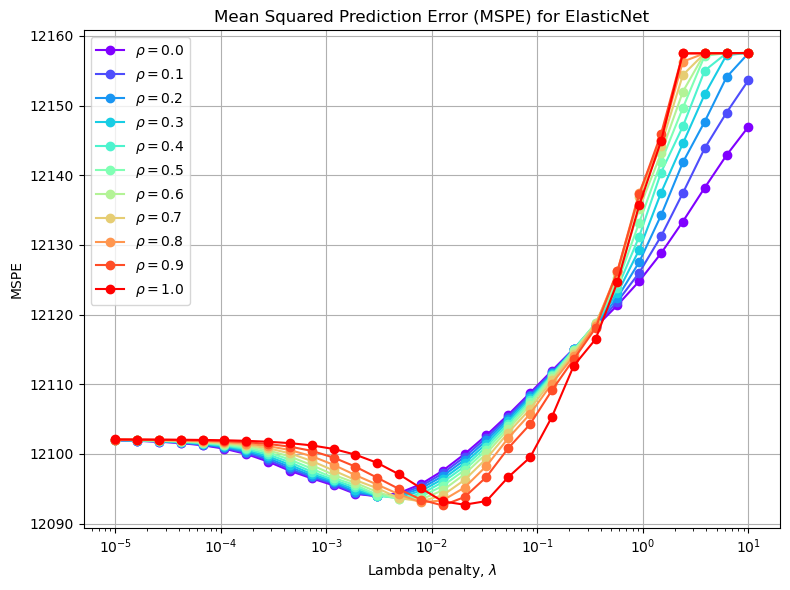

In [8]:
# Rainbow color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(final_mspe['y'].unique())))

plt.figure(figsize=(8, 6))
for idx, y_value in enumerate(final_mspe['y'].unique()):
    subset = final_mspe[final_mspe['y'] == y_value]
    plt.plot(subset['x'], subset['mspe'], marker='o', label=r'$\rho={}$'.format(round(y_value, 1)), color=colors[idx])

plt.xlabel(r'Lambda penalty, $\lambda$')
plt.ylabel('MSPE')
plt.title('Mean Squared Prediction Error (MSPE) for ElasticNet')
plt.legend()
plt.xscale('log') 
plt.grid(True)
plt.tight_layout()

plt.show()